# Can we reconstruct missing bands?

We have a set of 10 models to synthesize different numbers of spectral bands. Let's see how well all 16 bands can be synthesized from these models.


In [21]:
import os, sys
import glob

#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import xarray as xr

matplotlib.rc('text', usetex=True)

import seaborn as sns

sys.path.append('../')

sns.set(style="white")
sns.set_context("paper", font_scale=2.5)

import geonexl1b
import models
from models import SplitAutoEncoder, SplitGenVAE
import utils
from inference import domain_to_domain, load_model

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

## Get models

In [2]:
experiment_dir = '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/'
model_paths = {os.path.basename(f): f for f in glob.glob(experiment_dir + 'N_*')}
model_paths['N_16'] = '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/G16G17H8_16-16-16/'
print(model_paths)

{'N_01': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_01', 'N_02': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_02', 'N_05': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_05', 'N_09': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_09', 'N_06': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_06', 'N_15': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_15', 'N_12': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_12', 'N_11': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_11', 'N_07': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_07', 'N_10': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_10', 'N_14': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_N_bands/N_14', 'N_03': '/nobackupp10/tvandal/nex-ai-geo-t

## Get some data

In [3]:
sensor1 = 'G16'
sensor2 = 'G17'
geo = geonexl1b.L1bPaired('../data/Test/GOES16/GEONEX-L1B/', 
                          '../data/Test/GOES17/GEONEX-L1B/',
                           sensor1, sensor2)

files = geo.files(tile=None, year=2019, cachedir='./tmp')
#files = files.head(10)
files

year1  dayofyear1  hour1  minute1  \
timestamp     tile                                        
20190101_2000 h13v05   2019           1     20        0   
              h13v06   2019           1     20        0   
              h12v03   2019           1     20        0   
              h11v02   2019           1     20        0   
              h16v11   2019           1     20        0   
              h13v04   2019           1     20        0   
              h15v04   2019           1     20        0   
              h16v18   2019           1     20        0   
              h10v05   2019           1     20        0   
              h16v08   2019           1     20        0   
              h13v02   2019           1     20        0   
              h16v05   2019           1     20        0   
              h10v01   2019           1     20        0   
              h14v01   2019           1     20        0   
              h12v06   2019           1     20        0   
              h13v03   2019           1     20        0   
              h15v02   2019           1     20        0   
              h11v06   2019           1     20        0   
              h15v01   2019           1     20        0   
              h16v15   2019           1     20        0   
              h11v03   2019           1     20        0   
              h15v03   2019           1     20        0   
              h16v17   2019           1     20        0   
              h16v14   2019           1     20        0   
              h09v04   2019           1     20        0   
              h14v04   2019           1     20        0   
              h12v05   2019           1     20        0   
              h16v19   2019           1     20        0   
              h14v07   2019           1     20        0   
              h09v02   2019           1     20        0   
              h12v02   2019           1     20        0   
              h11v01   2019           1     20        0   
              h13v01   2019           1     20        0   
              h16v13   2019           1     20        0   
              h08v01   2019           1     20        0   
              h13v07   2019           1     20        0   
              h16v07   2019           1     20        0   
              h14v06   2019           1     20        0   
              h15v05   2019           1     20        0   
              h10v02   2019           1     20        0   
              h12v01   2019           1     20        0   
              h11v05   2019           1     20        0   
              h10v04   2019           1     20        0   
              h16v06   2019           1     20        0   
              h14v03   2019           1     20        0   
              h14v05   2019           1     20        0   
              h11v04   2019           1     20        0   
              h16v09   2019           1     20        0   
              h15v06   2019           1     20        0   
              h15v07   2019           1     20        0   
              h16v10   2019           1     20        0   
              h16v16   2019           1     20        0   
              h10v03   2019           1     20        0   
              h12v07   2019           1     20        0   
              h14v02   2019           1     20        0   
              h09v01   2019           1     20        0   
              h09v03   2019           1     20        0   
              h12v04   2019           1     20        0   
              h16v12   2019           1     20        0   

                                                                  file1  h1  \
timestamp     tile                                                            
20190101_2000 h13v05  ../data/Test/GOES16/GEONEX-L1B/h13v05/2019/001...  13   
              h13v06  ../data/Test/GOES16/GEONEX-L1B/h13v06/2019/001...  13   
              h12v03  ../data/Test/GOES16/GEONEX-L1B/h12v03/2019/001...  12   
              h11v02  ../da

In [4]:
load = lambda f: geonexl1b.L1bFile(f).load()[np.newaxis]
g16_data = np.vstack(files['file1'].map(load))
g17_data = np.vstack(files['file2'].map(load))

In [5]:
model_names = sorted(model_paths.keys())
curr_model, curr_params = load_model(model_paths['N_15'] + '/params.yaml')
curr_bands = [int(i) for i in curr_params['data']['G16']['bands'].split(',')]

make_prediction = lambda d: domain_to_domain(curr_model, d, 'G16', 'G17', bands1=curr_bands)[np.newaxis]
prediction = np.vstack([make_prediction(x) for x in g16_data])
prediction[np.isinf(prediction)] = np.nan

refl_overlap = range(0,5)
therm_overlap = range(5,15)

prediction.shape

../utils.py:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


Loaded model from step: 200000


(59, 300, 300, 16)

[0.04893183 0.05720932 0.07610157 0.01808652 0.0585935  0.05194461
 1.77378687 1.21207298 1.00185792 2.16063575 1.65544053 1.07493144
 1.5590032  1.50778816 1.51334295 1.49191155]
(array([540000,      0,      0,      0,      0,      0,     35, 453448,
       348317,  98200]), array([-2.00000405e-03,  3.07211980e+01,  6.14443961e+01,  9.21675941e+01,
        1.22890792e+02,  1.53613990e+02,  1.84337188e+02,  2.15060386e+02,
        2.45783584e+02,  2.76506782e+02,  3.07229980e+02]))
(array([540000,      0,      0,      0,      0,      0,      1, 448599,
       350967, 100433]), array([-6.71181679e-02,  3.05500153e+01,  6.11671488e+01,  9.17842823e+01,
        1.22401416e+02,  1.53018549e+02,  1.83635683e+02,  2.14252816e+02,
        2.44869950e+02,  2.75487083e+02,  3.06104217e+02]))
(36,)


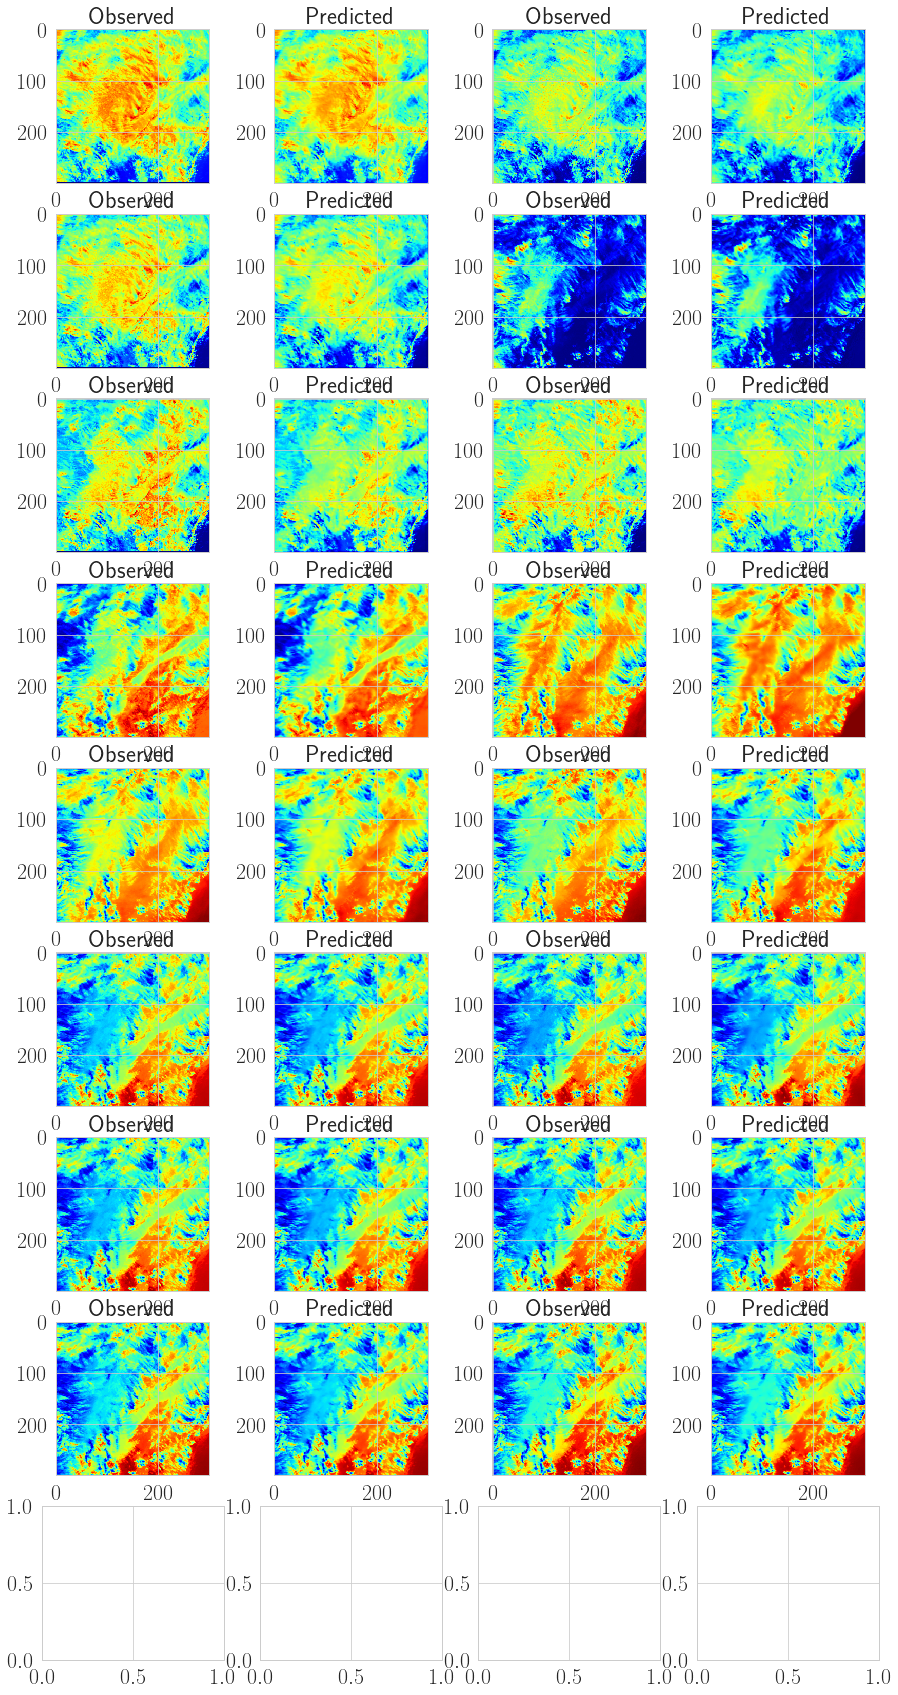

In [6]:
def compare(y, y_pred):
    err = y - y_pred
    print(np.nanmean(err**2, axis=(0,1))**0.5)
    print(np.histogram(y))
    print(np.histogram(y_pred))
    
    n_bands = y.shape[2]
    fig, axs = plt.subplots(n_bands//2+1, 2*2, figsize=(15,30))
    axs = np.ravel(axs)
    print(axs.shape)
    for i in range(n_bands):
        vmin = np.nanmin(y[:,:,i])
        vmax = np.nanmax(y[:,:,i])
        axs[i*2].imshow(y[:,:,i], cmap='jet', vmin=vmin, vmax=vmax)
        axs[i*2].set_title('Observed')
        axs[i*2+1].imshow(y_pred[:,:,i], cmap='jet', vmin=vmin, vmax=vmax)
        axs[i*2+1].set_title('Predicted')
    plt.show()
    

compare(g16_data[0], prediction[0])

## Error by Number of Bands

In [7]:
band_rmses = []
n_bands = [int(b.split("_")[1]) for b in model_names]


def psnr16(x, y):
    mse = np.nanmean((x-y)**2, axis=(1,2))
    refl_width = 1.6
    
    rad_width = 350-150
    #rad_width = 275-190
    
    psnr = np.zeros_like(mse)
    psnr[:,:6] = 10 * np.log10(refl_width**2 / mse[:,:6])
    psnr[:,6:] = 10 * np.log10(rad_width**2 / mse[:,6:])
    return psnr


predictions =  dict()
psnrs = dict()
for name in model_names:
    print(name)
    curr_model, curr_params = load_model(model_paths[name] + '/params.yaml')
    curr_bands = [int(i) for i in curr_params['data']['G16']['bands'].split(',')]
    
    band_err = []
    
    make_prediction = lambda d: domain_to_domain(curr_model, d, 'G16', 'G17', bands1=curr_bands)[np.newaxis]
    prediction = np.vstack([make_prediction(x) for x in g16_data])
    prediction[np.isinf(prediction)] = np.nan
    predictions[name] = prediction
    
    psnrs[name] = psnr16(g16_data, prediction)
    
    err = g16_data - prediction
    rmse = np.nanmean(err**2, axis=(0,1,2))**0.5
    if np.all(np.isfinite(rmse)):
        band_err.append(rmse)
    
    band_err = np.nanmean(np.vstack(band_err), axis=0)
    band_rmses.append(band_err)
    
band_rmses = np.vstack(band_rmses)

N_01


../utils.py:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


Loaded model from step: 130001
N_02
Loaded model from step: 130001
N_03
Loaded model from step: 130001
N_04
Loaded model from step: 200000
N_05
Loaded model from step: 200000
N_06
Loaded model from step: 200000
N_07
Loaded model from step: 200000
N_08
Loaded model from step: 200000
N_09
Loaded model from step: 200000
N_10
Loaded model from step: 200000
N_11
Loaded model from step: 200000
N_12
Loaded model from step: 200000
N_13
Loaded model from step: 200000
N_14
Loaded model from step: 200000
N_15
Loaded model from step: 200000
N_16
Loaded model from step: 199001


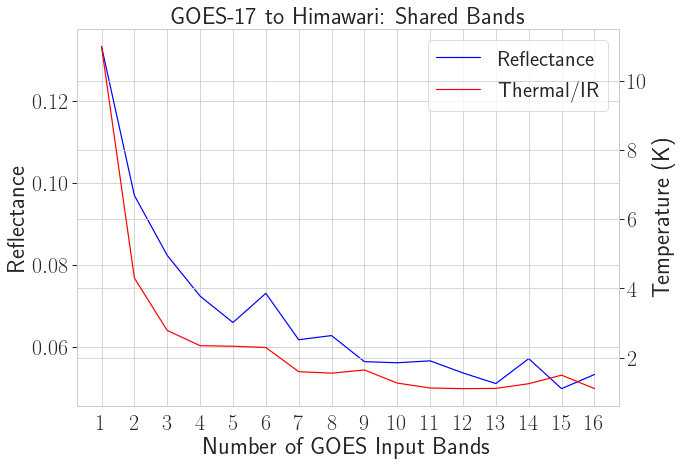

In [8]:
refl_error = np.nanmean(band_rmses[:,:5], axis=1)
tir_error = np.nanmean(band_rmses[:,5:], axis=1)

refl_error_std = np.nanstd(band_rmses[:,:5], axis=1)
tir_error_std = np.nanstd(band_rmses[:,5:], axis=1)


fig, axs = plt.subplots(1,1, figsize=(10,7))
ax1 = np.ravel(axs)[0]

ln1 = ax1.plot(n_bands, refl_error, label='Reflectance', color='blue')
ax1.set_ylabel("Reflectance")
ax2 = ax1.twinx()
ln2 = ax2.plot(n_bands, tir_error, label='Thermal/IR', color='red')
ax2.set_ylabel("Temperature (K)")


# added these three lines
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.xticks(n_bands)

ax1.set_title("GOES-17 to Himawari: Shared Bands")
ax1.set_xlabel("Number of GOES Input Bands")
plt.tight_layout()
plt.savefig("figures/drop_abi_bands_reconstruct_g16.png")
plt.show()

In [9]:
dfs = []
for key, arr in psnrs.items():
    df = xr.DataArray(arr, dims=['sample', 'Band'], coords=dict(Band=list(range(1,17))), name='PSNR').to_dataframe()
    df['Group'] = int(key.split("_")[1])
    dfs.append(df)
    
dfs = pd.concat(dfs).reset_index()
dfs['Type'] = ''
dfs['Type'][dfs['Band'] <= 6] = 'Reflectance'
dfs['Type'][dfs['Band'] >= 7] = 'TIR'
dfs

/nobackupp10/tvandal/miniconda3/envs/geonex/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nobackupp10/tvandal/miniconda3/envs/geonex/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


sample  Band       PSNR  Group         Type
0           0     1  25.351008      1  Reflectance
1           0     2  24.105998      1  Reflectance
2           0     3  22.979639      1  Reflectance
3           0     4  21.907389      1  Reflectance
4           0     5  20.585489      1  Reflectance
...       ...   ...        ...    ...          ...
15099      58    12  47.735643     16          TIR
15100      58    13  45.282356     16          TIR
15101      58    14  45.638003     16          TIR
15102      58    15  46.383662     16          TIR
15103      58    16  41.245563     16          TIR

[15104 rows x 5 columns]

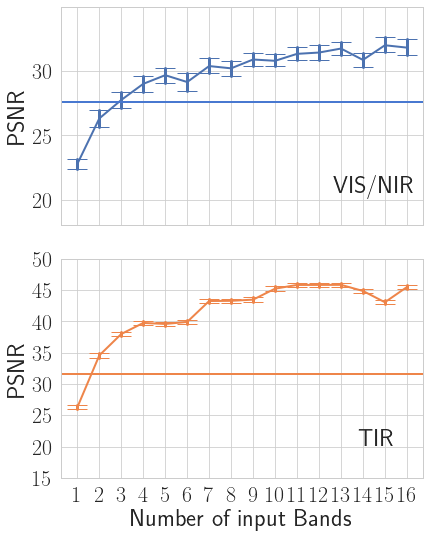

In [10]:
sensorpsnr = psnr16(g16_data, g17_data)
sensorvis = np.nanmean(sensorpsnr[:,:8])
sensortir = np.nanmean(sensorpsnr[:,8:])

dfs1 = dfs

f, axs = plt.subplots(2,1,figsize=(6.5,8), sharex=True)
axs = np.ravel(axs)
df_refl = dfs[dfs['Type'] == 'Reflectance']
df_tir = dfs[dfs['Type'] == 'TIR']

ax = sns.lineplot(data=dfs[dfs.Type=='Reflectance'], x='Group', y='PSNR', err_style='bars',
                  ax=axs[0],  palette='muted', legend='brief', markers='0', lw=2,
                  err_kws=dict(lw=3, capsize=10), ci=95)
ax.set_xticks(list(range(1,17)))
ax.set_yticks(list(range(15,35,5)))
ax.set_ylim([18,35])
ax.set_xlabel("")
ax.set_ylabel("PSNR")
ax.text(0.75, 0.15, "VIS/NIR", transform=ax.transAxes)
colors = sns.color_palette('muted')
ax.axhline(sensorvis, color=colors[0], lw=2)


ax = sns.lineplot(data=dfs[dfs.Type=='TIR'], x='Group', y='PSNR', err_style='bars',
                  ax=axs[1],  palette='muted', legend='brief', markers='0', lw=2,
                  err_kws=dict(lw=3, capsize=10), ci=95, color=colors[1])
ax.axhline(sensortir, color=colors[1], lw=2)
ax.text(0.82, 0.15, "TIR", transform=ax.transAxes)
ax.set_yticks(list(range(15,60,5)))
ax.set_ylim([15,50])
ax.set_xlabel("Number of input Bands")
ax.set_ylabel("PSNR")
#ax.set_xticks(list(range(0,17)))
plt.tight_layout()
plt.savefig("figures/drop_bands_psnr.png")
plt.show()


## Qualitative Example of Synthetic Reconstructions

In [11]:
sensor1 = 'G16'
geo = geonexl1b.GeoNEXL1b('../data/Test/GOES16/GEONEX-L1B/', sensor1)
qualfiles = geo.files(tile=None, year=2019, cachedir='./tmp')

vrange = list(range(3,5))
hrange = list(range(10,12))

subfiles = qualfiles[qualfiles['hour'] == 20]
pivotfiles = subfiles.pivot('v', 'h', 'file')
pivotfiles = pivotfiles[hrange].loc[vrange]
pivotfiles

h                                                 10  \
v                                                      
3  ../data/Test/GOES16/GEONEX-L1B/h10v03/2019/001...   
4  ../data/Test/GOES16/GEONEX-L1B/h10v04/2019/001...   

h                                                 11  
v                                                     
3  ../data/Test/GOES16/GEONEX-L1B/h11v03/2019/001...  
4  ../data/Test/GOES16/GEONEX-L1B/h11v04/2019/001...

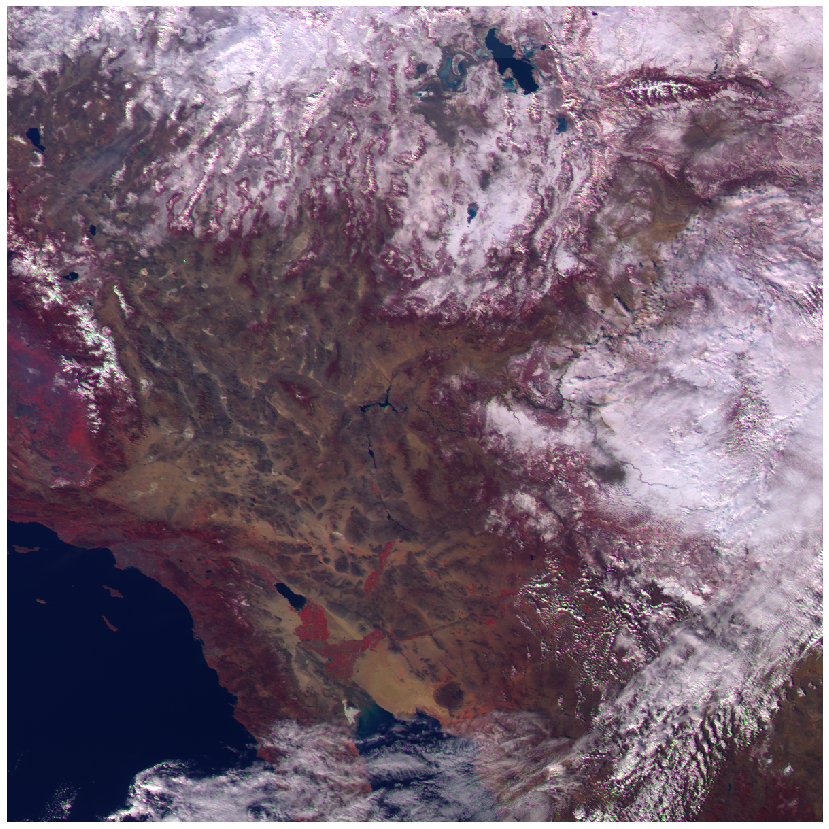

In [12]:
hsize = pivotfiles.shape[1]
vsize = pivotfiles.shape[0]

size = 600
data = np.empty((vsize*size, hsize*size, 16))
for ih in range(hsize):
    for iv in range(vsize):
        f = pivotfiles.values[iv, ih]
        data[iv*size:(iv+1)*size, ih*size:(ih+1)*size] = geonexl1b.L1bFile(f, resolution_km=1.).load()

fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.imshow(data[:,:,[2,1,0]])
plt.axis('off')
plt.show()

In [13]:
qualpredictions =  dict()
psnrs = dict()
qual_names = ['N_04', 'N_07', 'N_10', 'N_13', 'N_16']
input_data = data#np.transpose(data, (2,0,1))#[np.newaxis]
for name in qual_names:
    curr_model, curr_params = load_model(model_paths[name] + '/params.yaml')
    curr_bands = [int(i) for i in curr_params['data']['G16']['bands'].split(',')]
    #make_prediction = lambda d: domain_to_domain(curr_model, d, 'G16', 'G17', bands1=curr_bands)[np.newaxis]
    #prediction = np.vstack([make_prediction(x) for x in g16_data])
    print(input_data.shape)
    prediction = domain_to_domain(curr_model, input_data, 'G16', 'H8', bands1=curr_bands)
    prediction[np.isinf(prediction)] = np.nan
    qualpredictions[name] = prediction
    print(name, prediction.shape)

../utils.py:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


Loaded model from step: 200000
(1200, 1200, 16)
N_04 (1200, 1200, 16)
Loaded model from step: 200000
(1200, 1200, 16)
N_07 (1200, 1200, 16)
Loaded model from step: 200000
(1200, 1200, 16)
N_10 (1200, 1200, 16)
Loaded model from step: 200000
(1200, 1200, 16)
N_13 (1200, 1200, 16)
Loaded model from step: 199001
(1200, 1200, 16)
N_16 (1200, 1200, 16)


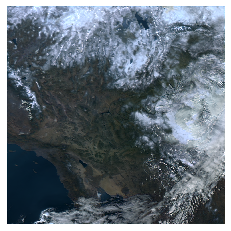

In [14]:
band = 0 #3
sample = 7

def green_correction(img, F):
    img[:,:,1] = (1-F) * img[:,:,1] + F * img[:,:,3]
    return img

def save_image(img, fname, cmap=None, vmin=None, vmax=None):
    h, w = 5, 5
    fig = plt.figure(frameon=False)
    fig.set_size_inches(w, h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    if vmin is None:
        vmin = np.nanmin(img)
    if vmax is None:
        vmax = np.nanmax(img)

    ax.imshow(img, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    fig.savefig(fname, dpi=200)
    plt.close()

    
band = 11

tir_vmin = np.nanmin(data[:,:,band])
tir_vmax = np.nanmax(data[:,:,band])

for name, arr in qualpredictions.items():
    img_file = 'figures/images/dropping_%s_rgb.png' % (name)
    arr = green_correction(arr, 0.15)
    save_image(arr[:,:,[2,1,0]], img_file)
    
    band_file = 'figures/images/dropping_%s_band%i.png' % (name, band+1)
    save_image(arr[:,:,band], band_file, cmap='jet', vmin=tir_vmin, vmax=tir_vmax)

#img_file = 'figures/images/observed_band_%02i.png' % (band)
#save_image(arr, img_file)

save_image(data[:,:,[2,1,0]], 'figures/images/observed_falsecolor.png')
save_image(data[:,:,band], 'figures/images/observed_band%i.png' % (band+1), cmap='jet', vmin=tir_vmin, vmax=tir_vmax)


plt.imshow(arr[:,:,[2,1,0]])
plt.axis('off')
plt.show()



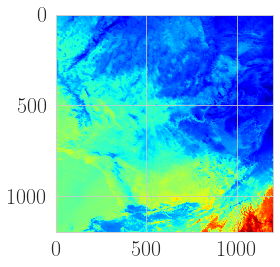

In [15]:
plt.imshow(data[:,:,11], cmap='jet')

## Cycling Figure

## Sharing Loss

In [16]:
sharing_dir = '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/'
sharing_model_paths = {os.path.basename(f): f for f in glob.glob(sharing_dir + 'Shared_*')}
sharing_model_paths['Shared_17'] = '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/G16G17H8_16-16-16/'

model_names = sorted(sharing_model_paths.keys())

print(sharing_model_paths)

band_rmses = []
shared = [int(b.split("_")[1])-1 for b in model_names]

print(shared)

predictions =  dict()
psnrs = dict()
for name in model_names:
    print(name, sharing_model_paths[name])
    try:
        curr_model, curr_params = load_model(sharing_model_paths[name] + '/params.yaml')
        curr_bands = list(range(0,16))

        make_prediction = lambda d: domain_to_domain(curr_model, d, 'G16', 'G17', bands1=curr_bands)[np.newaxis]
        prediction = np.vstack([make_prediction(x) for x in g16_data])
        prediction[np.isinf(prediction)] = np.nan
        predictions[name] = prediction

        psnrs[name] = psnr16(g16_data, prediction)
    except:
        continue

{'Shared_04': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_04', 'Shared_15': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_15', 'Shared_13': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_13', 'Shared_10': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_10', 'Shared_02': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_02', 'Shared_09': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_09', 'Shared_05': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_05', 'Shared_11': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_11', 'Shared_06': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_06', 'Shared_03': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_03', 'Shared_01': '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/shared/Shared_01'

In [17]:
dfs = []
for key, arr in psnrs.items():
    df = xr.DataArray(arr, dims=['sample', 'Band'], coords=dict(Band=list(range(1,17))), name='PSNR').to_dataframe()
    df['Group'] = int(key.split("_")[1]) - 1
    dfs.append(df)
    
dfs = pd.concat(dfs).reset_index()
dfs['Type'] = ''
dfs['Type'][dfs['Band'] <= 6] = 'Reflectance'
dfs['Type'][dfs['Band'] >= 7] = 'TIR'
dfs

/nobackupp10/tvandal/miniconda3/envs/geonex/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/nobackupp10/tvandal/miniconda3/envs/geonex/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


sample  Band       PSNR  Group         Type
0           0     1  14.371482      0  Reflectance
1           0     2  13.581126      0  Reflectance
2           0     3  13.071778      0  Reflectance
3           0     4  20.597833      0  Reflectance
4           0     5  18.291267      0  Reflectance
...       ...   ...        ...    ...          ...
16043      58    12  47.735643     16          TIR
16044      58    13  45.282356     16          TIR
16045      58    14  45.638003     16          TIR
16046      58    15  46.383662     16          TIR
16047      58    16  41.245563     16          TIR

[16048 rows x 5 columns]

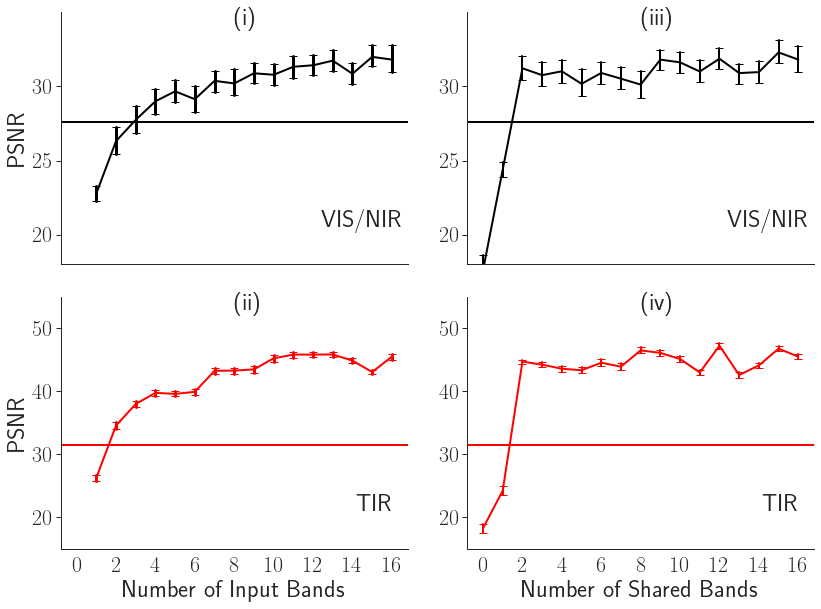

In [48]:
f, axs = plt.subplots(2,2,figsize=(12,9), sharex=True, sharey=False)
axs = np.ravel(axs)
sns.set_style("white", {"ytick.left": True, "ytick.right": False})

colors = ['black', 'red']#sns.color_palette('muted')


ax = sns.lineplot(data=dfs1[dfs1.Type=='Reflectance'], x='Group', y='PSNR', err_style='bars',
                  ax=axs[0],  color=colors[0], legend='brief', markers='0', lw=2,
                  err_kws=dict(lw=3, capsize=4), ci=99)
ax.set_xticks(list(range(1,17)))
ax.set_yticks(list(range(15,35,5)))
ax.set_ylabel("PSNR")
ax.text(0.75, 0.15, "VIS/NIR", transform=ax.transAxes)
ax.axhline(sensorvis, color=colors[0], lw=2)
sns.despine(right=True)
ax.text(0.50, 0.95, "(i)", transform=ax.transAxes)


ax = sns.lineplot(data=dfs1[dfs1.Type=='TIR'], x='Group', y='PSNR', err_style='bars',
                  ax=axs[2], legend='brief', markers='0', lw=2,
                  err_kws=dict(lw=3, capsize=4), ci=99, color=colors[1])
ax.set_ylim([15,50])
ax.axhline(sensortir, color=colors[1], lw=2)
ax.set_xlabel("Number of Input Bands")
ax.text(0.85, 0.15, "TIR", transform=ax.transAxes)
ax.text(0.50, 0.95, "(ii)", transform=ax.transAxes)



ax = sns.lineplot(data=dfs[dfs.Type=='Reflectance'], x='Group', y='PSNR', err_style='bars',
                  ax=axs[1],  color=colors[0], legend='brief', markers='o', lw=2,
                  err_kws=dict(lw=2, capsize=4), ci=99)
ax.set_xticks(list(range(0,17,2)))
ax.set_yticks(list(range(15,35,5)))
ax.axhline(sensorvis, color=colors[0], lw=2)
ax.text(0.75, 0.15, "VIS/NIR", transform=ax.transAxes)
ax.text(0.50, 0.95, "(iii)", transform=ax.transAxes)


ax = sns.lineplot(data=dfs[dfs.Type=='TIR'], x='Group', y='PSNR', err_style='bars',
                  ax=axs[3], legend='brief', markers='>', lw=2,
                  err_kws=dict(lw=2, capsize=4), ci=99, color=colors[1])
ax.set_ylim([15,50])
ax.axhline(sensortir, color=colors[1], lw=2)
ax.set_xlabel("Number of Shared Bands")
ax.text(0.85, 0.15, "TIR", transform=ax.transAxes)
ax.text(0.50, 0.95, "(iv)", transform=ax.transAxes)


ax.set_xticks(list(range(0,17,2)))
ax.set_yticks(list(range(20,60,10)))


axs[0].set_ylim([18,35])
axs[2].set_ylim([15,55])
axs[1].set_ylim([18,35])
axs[3].set_ylim([15,55])
axs[1].set_ylabel("")
axs[3].set_ylabel("")

plt.tight_layout()
plt.savefig("figures/dropping_and_sharing.pdf")
plt.savefig("figures/dropping_and_sharing.svg")

plt.show()

In [45]:
sns.axes_style()

{'axes.facecolor': 'white',
 'axes.edgecolor': '.15',
 'axes.grid': False,
 'axes.axisbelow': True,
 'axes.labelcolor': '.15',
 'figure.facecolor': 'white',
 'grid.color': '.8',
 'grid.linestyle': '-',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'image.cmap': 'rocket',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'patch.force_edgecolor': True,
 'xtick.bottom': False,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True}

## Lets look at the overlapping tiles of ABI and AHI

In [ ]:
l1bpaired = geonexl1b.L1bPaired('/nex/datapool/geonex/public/GOES17/GEONEX-L1B/', 
                                '/nex/projects/goesscratch/weile/AHI05_java/output/HDF4',
                                'ABI', 'AHI')
paired_tiles = l1bpaired.tiles()
tile = 'h00v06' #paired_tiles[0]
paired_files = l1bpaired.files(tile=tile, year=2019)
paired_files = paired_files.sample(frac=1).reset_index(drop=True)

In [ ]:
ahi_overlap = [0] + list(range(2,16))
abi_overlap = list(range(0,3)) + list(range(4,16))

band_rmses = []
n_bands = [int(b.split("_")[1]) for b in model_names]

ahi_abi_err = []

for name in model_names:
    curr_model, curr_bands = load_model(model_paths[name]) 
    band_err = []
    for i, row in paired_files.iloc[:5].iterrows():
        abi_file = row['file1']
        ahi_file = row['file2']
        print(abi_file, ahi_file)

        abi_data = geonexl1b.L1bFile(abi_file).load()
        ahi_data = geonexl1b.L1bFile(ahi_file).load()

        if name == model_names[0]:
            err = abi_data[:,:,abi_overlap] - ahi_data[:,:,ahi_overlap]
            rmse = np.nanmean(err**2, axis=(0,1))**0.5
            ahi_abi_err.append(rmse)

        ahi_estimate = abi_to_ahi(curr_model, abi_data, curr_bands)
        err = abi_data[:,:,abi_overlap] - ahi_estimate[:,:,ahi_overlap]
        rmse = np.nanmean(err**2, axis=(0,1))**0.5
        if np.all(np.isfinite(rmse)):
            band_err.append(rmse)
    
    band_err = np.nanmean(np.vstack(band_err), axis=0)
    band_rmses.append(band_err)

band_rmses = np.vstack(band_rmses)
ahi_abi_err = np.vstack(ahi_abi_err)

In [ ]:
refl_error = np.nanmean(band_rmses[:,:5], axis=1)
tir_error = np.nanmean(band_rmses[:,5:], axis=1)

refl_abiahi_error = np.nanmean(ahi_abi_err[:,:5])
tir_abiahi_error = np.nanmean(ahi_abi_err[:,5:])

fig, axs = plt.subplots(1,1, figsize=(10,7))
ax1 = np.ravel(axs)[0]

ln1 = ax1.plot(n_bands, refl_error, label='Reflectance', color='blue')
ax1.set_ylabel("Reflectance")
ax2 = ax1.twinx()
ln2 = ax2.plot(n_bands, tir_error, label='Thermal/IR', color='red')
ax2.set_ylabel("Temperature (K)")

ln3 = ax1.axhline(refl_abiahi_error, color='blue', ls='--', label='Reflectance - Sensor Error')
ln4 = ax2.axhline(tir_abiahi_error, color='red', ls='--', label='Thermal/IR - Sensor Error')

# added these three lines
lns = [ln1[0],ln2[0], ln3, ln4]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.xticks(n_bands)

ax1.set_title("GOES-17 to Himawari: Overlapping Tiles")
ax1.set_xlabel("Number of GOES Input Bands")
plt.savefig("figures/drop_abi_bands_reconstruct_ahi_overlap.png")
plt.show()


## Lets try to extract signal and noise with G16 and G17

sensor_error = (G16_obs - G17_obs) <br>
synthetic_error = (G16_recon - G17_recon)

G16 -> G16_recon <br>
G16 -> G17_synth <br>
G17 -> G17_recon <br>
G17 -> G16_synth <br>
G16 -> G16_H8_synth <br>
G17 -> G17_H8_synth <br>

G16_recon_err = (G16_recon - G16) <br>
G17_recon_err = (G17_recon - G17)



In [ ]:
goespaired = geonexl1b.L1bPaired('/nex/datapool/geonex/public/GOES16/GEONEX-L1B/', 
                                 '/nex/datapool/geonex/public/GOES17/GEONEX-L1B/',
                                 'ABI', 'ABI')
paired_tiles = goespaired.tiles()

tile = 'h11v03'# paired_tiles[10]
goes_files = goespaired.files(tile=tile, year=2019)
goes_files = goes_files.sample(frac=1).reset_index(drop=True)
goes_files
bands = list(range(0,16))


g16g17h8_config = '/nobackupp10/tvandal/nex-ai-geo-translation/configs/G16_G17_H8_full.yaml'
params = utils.get_config(g16g17h8_config)
g16g17h8_model = SplitGenVAE(params)
g16g17h8_model.to(device)
checkpoint_path = os.path.join(params['model_path'], 'checkpoint.flownet.pth.tar')
checkpoint = torch.load(checkpoint_path)
g16g17h8_model.load_state_dict(checkpoint['gen_state'])
print(f"Checkpoint: {checkpoint_path}")

In [ ]:
band_rmses = []
n_bands = [int(b.split("_")[1]) for b in model_names]
results = dict()

print(bands)
rmse_func = lambda x, y: np.nanmean((x-y)**2, axis=(0,1))**0.5

bias_func = lambda x, y: np.nanmean(x-y, axis=(0,1))

results = dict(sensor_noise=[], sensor_bias=[], synthetic_error=[], synthetic_bias=[],
               synthetic_g16_error=[], synthetic_g17_error=[],
               recon_g16_error=[], recon_g17_error=[], synthetic_HW8=[])
sensor_noise_collection = []
for i, row in goes_files.iloc[:50].iterrows():
    file_g16 = row['file1']
    file_g17 = row['file2']
    print(file_g16, file_g17)
    g16_data = geonexl1b.L1bFile(file_g16).load()
    g17_data = geonexl1b.L1bFile(file_g17).load()

    if np.any(~np.isfinite(g16_data)) or np.any(~np.isfinite(g17_data)):
        continue

    sensor_noise = rmse_func(g16_data[:,:,bands], g17_data[:,:,bands])
    results['sensor_noise'].append(sensor_noise)
    results['sensor_bias'].append(bias_func(g16_data[:,:,bands], g17_data[:,:,bands]))

    g17_synth = domain_to_domain(g16g17h8_model, g16_data, 'G16', 'G17', bands1=bands, bands2=bands)
    g16_synth = domain_to_domain(g16g17h8_model, g17_data, 'G17', 'G16', bands1=bands, bands2=bands)
    g_synth_avg = (g17_synth + g16_synth)/2
    
    g16_h8 = domain_to_domain(g16g17h8_model, g16_data, 'G16', 'H8', bands1=bands, bands2=bands)
    g17_h8 = domain_to_domain(g16g17h8_model, g17_data, 'G17', 'H8', bands1=bands, bands2=bands)
    
    synthetic_error = rmse_func(g17_synth, g16_synth)

    results['synthetic_error'].append(synthetic_error)
    results['synthetic_bias'].append(bias_func(g17_synth, g16_synth))
    results['synthetic_HW8'].append(rmse_func(g16_h8, g17_h8))

    g16_recon = domain_to_domain(g16g17h8_model, g16_data, 'G16', 'G16', bands1=bands, bands2=bands)
    g17_recon = domain_to_domain(g16g17h8_model, g17_data, 'G17', 'G17', bands1=bands, bands2=bands)
    
    recon_g16_error = rmse_func(g16_data[:,:,bands], g16_recon)
    results['recon_g16_error'].append(recon_g16_error)
    recon_g17_error = rmse_func(g17_data[:,:,bands], g17_recon)
    results['recon_g17_error'].append(recon_g17_error)
    
    g16_cross_error = rmse_func(g16_data[:,:,bands], g16_synth)
    g17_cross_error = rmse_func(g17_data[:,:,bands], g17_synth)
    results['synthetic_g16_error'].append(g16_cross_error)
    results['synthetic_g17_error'].append(g17_cross_error)

    
results['sensor_noise'] = np.nanmean(np.vstack(results['sensor_noise']), axis=0)
results['synthetic_error'] = np.nanmean(np.vstack(results['synthetic_error']), axis=0)
results['synthetic_bias'] = np.nanmean(np.vstack(results['synthetic_bias']), axis=0)
results['recon_g16_error'] = np.nanmean(np.vstack(results['recon_g16_error']), axis=0)
results['recon_g17_error'] = np.nanmean(np.vstack(results['recon_g17_error']), axis=0)
results['synthetic_g16_error'] = np.nanmean(np.vstack(results['synthetic_g16_error']), axis=0)
results['synthetic_g17_error'] = np.nanmean(np.vstack(results['synthetic_g17_error']), axis=0)
results['sensor_bias'] = np.nanmean(np.vstack(results['sensor_bias']), axis=0)
results['synthetic_HW8'] = np.nanmean(np.vstack(results['synthetic_HW8']), axis=0)

results

In [ ]:
df = pd.DataFrame(results)
df['Band'] = np.arange(1,17)
df = df.set_index("Band")

In [ ]:
latextable = df.round(3).to_latex()
with open("figures/g16_g17_table.txt", "w") as wf:
    wf.write(latextable)
df.round(3)